# Preparations


In [0]:
#!rm -r data

In [0]:
import os
import io
import pickle
import requests
import zipfile
from pathlib import Path
import numpy as np

from PIL import Image
from scipy import ndimage
from imageio import imread, imsave
from skimage import img_as_float, color, exposure
from skimage.transform import resize
from skimage.feature import peak_local_max, hog
from skimage.segmentation import clear_border
from skimage.morphology import label
from skimage.measure import regionprops

from sklearn import neighbors
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

## Character extraction

Functions related to character extraction from an image of a page of text

In [0]:
# read file with the image and convert it to binary image -
# ndarray with 1.0 and 0.0
def get_binary_image(path_to_image):
  image = Image.open(path_to_image).convert('L')
  image = np.asarray(image, )

  #apply threshold in order to make the image binary
  bw = (image < 120).astype(np.float)

  return bw

In [0]:
# Returns the list of bboxes from the image.
# Image should be an np 2D array of 0.0 and 1.0
# bbox is a tuple (minr, minc, maxr, maxc) where first 2 elements
# are coordinates of top left corner of a character and the last 2 elements
# are coordinates of bottom right corner of a character.
def get_bboxes(binary_image):
  print("getting bboxes from image")
  bboxes = []

  # remove artifacts connected to image border
  cleared = binary_image.copy()
  clear_border(cleared)

  # label image regions
  label_image = label(cleared,neighbors=8)
  borders = np.logical_xor(binary_image, cleared)
  label_image[borders] = -1

  for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    # Skip small regions
    if maxr - minr > len(binary_image) / 250:  # better to use height rather than area.
      bboxes.append((minr, minc, maxr, maxc))
  return bboxes


In [0]:
def enlarge_bboxes(bboxes, enlarge_coef):
  enlarged_bboxes = []
  for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    height = maxr - minr
    h_extension = (int)(height * enlarge_coef)
    enlarged_bbox = (minr - h_extension, minc, maxr, maxc)
    enlarged_bboxes.append(enlarged_bbox)
  return enlarged_bboxes

In [0]:
# Sorts the bboxes left->right, top->bottom and returns 2d array of bboxes
def sort_bboxes(bboxes):
  print("sorting bboxes")
  lines = list()
  first_in_line = ''
  counter = 0

  # worst case scenario there can be 1 character per line
  for x in range(len(bboxes)):
      lines.append([])

  for character in bboxes:
      if first_in_line == '':
          first_in_line = character
          lines[counter].append(character)
      elif abs(character[0] - first_in_line[0]) < (first_in_line[2] - first_in_line[0]):
          lines[counter].append(character)
      elif abs(character[0] - first_in_line[0]) > (first_in_line[2] - first_in_line[0]):
          first_in_line = character
          counter += 1
          lines[counter].append(character)

  for x in range(len(lines)):
    lines[x].sort(key=lambda tup: tup[1])

  return lines

In [0]:
def get_images_from_bboxes(bw, lines):
  print("getting images from bboxes")
  # tl - top left,
  # tr - top right,
  # bl - bottom left,
  # br - bottom right
  final = list()
  tr_prev = 0
  prev_line_br = 0

  for line_index in range(len(lines)):
      for char_index in range(len(lines[line_index])):
          tl_next = lines[line_index][char_index][1]
          bl_next = lines[line_index][char_index][0]
          # if next bbox does not intersect with the previous one
          # and
          if tl_next > tr_prev and bl_next > prev_line_br:
              # Get coordinates of a current char
              tl, tr, bl, br = lines[line_index][char_index]
              # Extract image 
              letter_raw = bw[tl:bl, tr:br]
              # Resize it
              letter_norm = resize(letter_raw, (20, 20))
              # Add to the output
              final.append(letter_norm)
              # Update the previous right line value
              tr_prev = lines[line_index][char_index][3]
          # if it was last char in a row
          if char_index == (len(lines[line_index]) - 1):
              # set prev_line_br to the bottom left pixel of the last char
              prev_line_br = lines[line_index][char_index][2]
      tr_prev = 0
      tl_next = 0
  return final

In [0]:
# Shows character borders on the image
def show_bboxes(path_to_image):
  bw = get_binary_image(path_to_image=path_to_image)

  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(32, 32))
  ax.imshow(bw, cmap='jet')

  bboxes = get_bboxes(bw)
  
  for minr, minc, maxr, maxc in bboxes:
    height = maxr - minr
    width = maxc - minc
    rect = mpatches.Rectangle((minc, minr), width, height,
                                    fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)

  plt.show()

In [0]:
# Draws already existing bboxes on the image
def show_bboxes2(bw, lines):
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(32, 32))
  ax.imshow(bw, cmap='jet')

  for line in lines:
    line_length = len(line)
    for minr, minc, maxr, maxc in line:
      rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=1)
      ax.add_patch(rect)
  plt.show()

In [0]:
# Returns list of normalised character pictures from image
# image_path - path to a file
def get_char_images_from_image(image_path):
   # Reading the file and converting it into binary image
    bw = get_binary_image(image_path)

    # Getting bboxes with letters
    bboxes = get_bboxes(binary_image=bw)

    # Sorting the detected bboxes left->right, top->bottom
    lines = sort_bboxes(bboxes)

    #show_bboxes2(bw, lines)

    # Getting list of actual images of characters, normalised to 20x20
    char_images = get_images_from_bboxes(bw, lines)

    return char_images

## Dataset creation

Functions which related to the sorting of extracted training data by folders

In [0]:
# Getting the snippets of training characters and putting them
# into corresponding folders
# training_files - list of pathes to the images with training pages
# out_folder - folder where to put classes (with / in the end)
# alphabet - repeating string in the training files used for sorting
def sort_chars_to_folders(training_files, out_folder, alphabet, enlarge_bboxes_coef=0.0):
  if not alphabet:
    raise ValueError("alphabet should not be empty")
  
  
  # Fixing windows not allowing to create folders with both low and up case
  for character in alphabet:
    if character.isupper():
      folder_to_create = character + '_'
    else:
      folder_to_create = character

    # Creating folders
    Path(out_folder + folder_to_create).mkdir(parents=True, exist_ok=True)

  # Prefix to all snippets in all training files
  name_counter = 0
  for training_file in training_files:
    # Reading the file and converting it into binary image
    bw = get_binary_image(training_file)

    # Getting bboxes with letters
    bboxes = get_bboxes(binary_image=bw)

    if enlarge_bboxes_coef > 0.0:
      # increase height of each bbox to include umlauts
      bboxes = enlarge_bboxes(bboxes=bboxes, enlarge_coef=enlarge_bboxes_coef)

    # Sorting the detected bboxes left->right, top->bottom
    lines = sort_bboxes(bboxes)

    # show_bboxes2(bw, lines)

    # # potential fix for letter 'Ы'
    # # didn't work because other letters were merged together as well
    # for line in lines:
    #   line_length = len(line)
    #   for bbox_id in range(line_length - 1, 0, -1):
    #       minr, minc, maxr, maxc = line[bbox_id]
    #       minr_prev, minc_prev, maxr_prev, maxc_prev = line[bbox_id-1]
    #       # If boxes are too close to each other along the x axis
    #       if (minc - maxc_prev) < 9:
    #           # Delete the current bbox which is I
    #           del line[bbox_id]
    #           # And extend the previous bbox
    #           line[bbox_id-1] = (minr_prev, minc_prev, maxr_prev, maxc)
    #           #bbox_id -= 1

    # Getting list of actual images of characters, normalised to 20x20
    char_images = get_images_from_bboxes(bw, lines)

    # Saving the images to the corresponding folders
    string_counter = 0
    alphabet_length = len(alphabet)
    print(f"alphabet_length = {alphabet_length}")

    for char_image in char_images:
      if string_counter > alphabet_length - 1:
        string_counter = 0
      # Convert to uint8 before saving to suppress warnings
      char_image = (char_image*255).astype(np.uint8)

      # Fixing windows not allowing to create folders with both low and up case 
      folder_to_save = alphabet[string_counter]
      if folder_to_save.isupper():
        folder_to_save += '_'

      imsave(out_folder + folder_to_save + '/' + str(name_counter) + '_snippet.png', char_image)

      string_counter += 1
      name_counter += 1

In [0]:
# Save snippets to the zip folder for manual sorting
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
          ziph.write(os.path.join(root, file))

## Image recognition

Code related to the recognition of the characters

In [0]:
# pixels per cell and cells per block were chosen by bruteforsing
# all the possible combinations and picking the one giving the best accuracy
# for pixels per cell from 2 to 10
# for cells per block from 1 to 7
def get_hog_features(image):
  return hog(image,
             orientations=12,
             pixels_per_cell=(2, 2),
             cells_per_block=(1, 1))

In [0]:
# Get the training data and labels from folders
# training_root - path to a folder with sorted snippet folders.
# Requires '/' in the end
# returns (data, labels) tuple
def get_data_and_labels(training_root):
  char_folders = os.listdir(training_root)
  data = []
  labels = []

  for folder in char_folders:
    path_to_char_folder = training_root + folder +'/'
    char_filenames = sorted([filename for filename in os.listdir(path_to_char_folder) if filename.endswith('.png')])
    char_filenames = [path_to_char_folder + filename for filename in char_filenames]

    print(f"found: {len(char_filenames)} snippets in folder {folder}")

    print(f"adding {folder} to data and labels")
    for filename in char_filenames:
        #read the images
        image = imread(filename)
        #flatten it
        hog_features = get_hog_features(image)
        data.append(hog_features)
        # Add the actual letter name to label not 'A_' for capitals
        labels.append(folder[0])

    print(f'Finished adding {folder} samples to data and labels')
  return (data, labels)

In [0]:
# Returns label associated with the image of a letter using the passed classifier
def recognise_letter(letter_image, clf):
  hog_features = get_hog_features(letter_image)
  result_type = clf.predict(hog_features.reshape(1,-1))
  return result_type[0]

## Data loading

This code loads the data required for the coursework

In [0]:
# Get data
import tarfile

r = requests.get('https://github.com/Satilianius/COM2028/raw/master/Classifier/data.tar')
with tarfile.open(fileobj=io.BytesIO(r.content), mode="r") as t:
  t.extractall(path='/content/')

The previous code contains functions, which are used in more than one tasks. Run it and then proceed to the task you need. 


# Task 1: Recognising printed letters of multiple languages

## 1.1 Russian language

### 1.1.1 Dataset creation

The following code is an unsuccessful attempt to create a training samples automatically from png images of pages of character samples. It used a sample code provided for the coursework, but for the reasons which will be mentioned later didn't quite work - the letter snippets had to be sorted by folders manually in the end. However, the code was helpful in the initial character extraction

In [0]:
# Checking if borders of characters are correctly recognised on a training images
show_bboxes('/content/data/task_1/rus/images/training_Page_1.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_2.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_3.png')
show_bboxes('/content/data/task_1/rus/images/training_Page_4.png')

The letter 'Ы' is recognised by region separtor as 2 separate regions.
The alphabet to pass into sorting function is changed to bypass it - the first region which is similar to 'ь' will go to the according folder and the second region will go to i or I folder.


Later, during post-processing if 'i' will be recognised, it will mean that this and the previous character are a part of one letter and replaced by 'Ы'

In [0]:
# String of all possible classes
rus_chars = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"

In [0]:
# Filling the folders with character snippets
# Will overwrite the existing files

out_folder = '/content/data/task_1/rus/training_classes/'
training_files = ['/content/data/task_1/rus/images/training_Page_1.png',
                  '/content/data/task_1/rus/images/training_Page_2.png',
                  '/content/data/task_1/rus/images/training_Page_3.png',
                  '/content/data/task_1/rus/images/training_Page_4.png']
sort_chars_to_folders (training_files, out_folder, rus_chars, enlarge_bboxes=0.5)

At this stage the letters are not being properly sorted. So next step is to save them to archive, download it, sort the snippets manually and upload back. The sorted lettres will live in 'training_classes_rus_sorted' folder.

Usualy there are two reasons for snippets not being properly sorted:
- One letter was recognised as two ('ж' as '>' and '<' in thin fonts)
- two regions were recognised as one ('Ы')
- character for some reason was just not recognised 

In any case all the next letters on this page are shifted by 1 when sorted to folders. The next code helps to shift them to the proper position after the first not properly recognised snippet was found.

In [0]:
# Gets id of the source class and offset and returns the name of the folder
# of destination class. Name includes '_' for uppercase letters

def get_dest_folder(source_class_id, offset):
  # class - letter without _ for upcase
  # folder - folder name with _ for upcase
  alphabet = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"

  # Get destination class and source class in form with '_' if needed
  destination_class_id = source_class_id + offset

  # wrap around if offset positive
  offset_remainder = destination_class_id - len(alphabet)
  if offset_remainder >= 0:
    destination_class_id = offset_remainder

  # wrap around if offset negative
  if destination_class_id < 0:
    destination_class_id = len(alphabet) + destination_class_id

  destination_folder = folder_alphabet[destination_class_id]

  if destination_folder.isupper():
    destination_folder += '_'

  return destination_folder
  

# Shifts all snippets starting from the start_snippet_id which located in folder
# with source_class_id by offset. last_snippet_id - last snippet to be moved 
def shift_all_snippets(start_snippet_id, source_class_id, offset, last_snippet_id):
  folder_alphabet = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"
  root_folder = '/content/data/task_1/rus/training_classes'
  snippet_id = start_snippet_id


  while snippet_id <= last_snippet_id:
    source_class = folder_alphabet[source_class_id]
    source_folder = source_class + '_' if source_class.isupper() else source_class
    dest_folder = get_dest_folder(source_class_id, offset)
    snippet_name = str(snippet_id) + '_snippet.png'
    source_file = root_folder + '/' + source_folder + '/' + snippet_name
    dest_file =  root_folder + '/' + dest_folder + '/' + snippet_name

    print(f"Shifting: source class id: {source_class_id},",\
          f"source_class: {source_class}, ",\
          f"dest_folder: {dest_folder}, ",\
          f"source_file: {source_file}, ",\
          f"dest_file: {dest_file}")
    try:
      os.rename(source_file, dest_file)
    except FileNotFoundError as e:
      print(f'snippet {snippet_name} not found in folder {source_folder}, end of the file reached')
      return
    source_class_id = 0 if (source_class_id + 1 >= len(folder_alphabet)) else source_class_id + 1 
    snippet_id += 1

# Not for calling from other functions.
# Returns id of letter in alphabet. For 'ь' and 'Ь' returns tuples of ids
def get_class_id(class_):
  alphabet = "абвгдеёжзийклмнопрстуфхцчшщъьiьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЬIЬЭЮЯ"
  if (class_ == 'ь'):
    return (28,30)
  if class_ == 'Ь':
    return (62,64)
  return alphabet.index(class_)


In [0]:
# Get the index of letter in the alphabet string to pass to shift_all_snippets
# get_class_id('Э')

In [0]:
# After the first snippet being put in a wrong folder was found -
# shift all the snippets after it to the corresponding folder by the offset
# shift_all_snippets(start_snippet_id=1892, source_class_id=65, offset=1, last_snippet_id=2096)

Trying to download folders with snippets I realised that not all the systems properly handle letters as folder names - zipfile just didn't create the folders with some of the capital letters as names. I tried to create them in windows explorer and it complained that the folder with this name is already exist. However there was only folder with lowercase letter as a name. So I had to rename the folders with capitals, adding '_' after the actual letters

Another problem was that zipfile does not unzip folders with cyrillic names properly, which resulted in a folders with meaningless symbols as names. After some unsuccessful attempts to find encoding settings in zipfile, I have switched to tar archives. Tarfile module worked better.

In [0]:
# This block can be skipped. Already sorted files are in
# '/content/data/task_1/rus/training_classes_rus_sorted'

# Uncomment to create an archive of training snippets
# zipf = zipfile.ZipFile('/content/data/task_1/rus/training_classes.zip', 'w', zipfile.ZIP_DEFLATED)
# zipdir('/content/data/task_1/rus/training_classes', zipf)
# zipf.close()

### 1.1.2 Creating and training classifiers

After creating a datasets of character snippets, we can finally train the classifiers and let them recognise some text

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


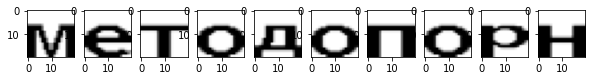

In [0]:
# Show first 10 letter snippets from the test image to check
# that letter extraction works as intended
letters = get_char_images_from_image('/content/data/task_1/rus/images/testing.png')
# Show letters
fig, axes = plt.subplots(ncols=10, nrows=1, figsize=(10, 1))
for i in range(0,10):
  letter = letters[i]
  axes[i].imshow(letter, cmap='Greys')

In [0]:
# Recognises the text from an image of a page in Russian using passed classifier

# Gets path to an image and trained classifier to use
# returns a string with the recognised text
def recognise_rus_text(image_path, classifier):
  recognised_letters = []

  # Get all the letter images from the source image
  letters = get_char_images_from_image(image_path)

  # Recognise each letter using the passed classifier
  for letter in letters:
    new_letter = recognise_letter(letter, classifier)

    # if it is the second part of the small letter 'ы'
    if (new_letter == 'i') and (len(recognised_letters) > 0):
      # delete the previous part of the letter
      del recognised_letters[-1]
      # and append lowercase 'ы' instead
      recognised_letters.append('ы')

    # if it is the second part of the capital letter 'Ы'
    elif (new_letter == 'I') and (len(recognised_letters) > 0):
      # delete the previous part of the letter
      del recognised_letters[-1]
      # and append uppercase 'Ы' instead
      recognised_letters.append('Ы')
      
    else:  
      recognised_letters.append(new_letter)

  recognised_text = ''.join(recognised_letters)
  return recognised_text

#### 1.1.2.1 SVM classifier

First we will use the dataset where uppercase letters are considered separate classes. 

This dataset is located in '/content/data/task_1/rus/training_classes_sorted/' folder

In [0]:
# Get data and labels to train SVM
data_up, labels_up = get_data_and_labels('/content/data/task_1/rus/training_classes_sorted/')

found: 31 snippets in folder п
adding п to data and labels
Finished adding п samples to data and labels
found: 31 snippets in folder ш
adding ш to data and labels
Finished adding ш samples to data and labels
found: 31 snippets in folder Х_
adding Х_ to data and labels
Finished adding Х_ samples to data and labels
found: 31 snippets in folder о
adding о to data and labels
Finished adding о samples to data and labels
found: 31 snippets in folder ч
adding ч to data and labels
Finished adding ч samples to data and labels
found: 30 snippets in folder Д_
adding Д_ to data and labels
Finished adding Д_ samples to data and labels
found: 31 snippets in folder з
adding з to data and labels
Finished adding з samples to data and labels
found: 31 snippets in folder Ц_
adding Ц_ to data and labels
Finished adding Ц_ samples to data and labels
found: 31 snippets in folder Й_
adding Й_ to data and labels
Finished adding Й_ samples to data and labels
found: 31 snippets in folder щ
adding щ to data and 

In [0]:
# Create and train SVM classifier
print('Training the SVM')
#create the SVC
svm_clf = LinearSVC(dual=False,verbose=1)
#train the svm
svm_clf.fit(data_up, labels_up)

In [0]:
# Now we finally try to recognise text from the test png 
test_text_recognised = recognise_rus_text('/content/data/task_1/images/rus/testing.png', svm_clf)
print(test_text_recognised)

getting bboxes from image
sorting bboxes
getting images from bboxes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


методопорнБГхвепоровнабОрфОЖихалгОриТмОвОбУЧениЯсУЧиТелемиспОлнзУюЩихсЯдлЯзадаЧюассииКацииирегрессиОннОганализапринадлеЖиТсемейсвУлинейннГхюассииКаТОрОвимОЖТТаМрассмаТриваТнсЯККспециалнннГйслУЧайреулЯризациипОтихОнОвУосОбнГмсвОйсвОммеТОдаОпОрннГхвеКОрОвЯвлЯеТсЯнепрернГвнОеУменнШениеэмпириЧесКОйОШибКиюассииКациииУвелиЧениезазОрапОэТОмУмеТОдТаСизвесТенКаКтетОбШэссччктОрэстэксчтэБнчЮтззОрОтоснОвнаЯидеЯмеТОдаперевОдисОдннГхвеКОрОввпрОсТрансТвОбОлеевнГсОКОйразмернОсТиипОисКразделЯюЩейгиперплОсКОсисмаКсималбннГмзазОрОмвэТОмпрОсТрансТвевепараллелнннГхгиперплОсКОсТисТрОЯТсЯпООеимсТОрОнамгиперплОсКОсТиразделЯюЩейюасснГРзЭеЯюШейечПеПОСБСБюбдеТгиперплОсКОсТнмаКсимизирУюЩаЯрассТОЯниедОдвУхпараллелнннГхгиперплОсКОсейАлгриТмрабОТаеТвпредпОлОЖнииЧТОЧембОлнШеразнийилирассОЯниемеЁУэТимипараллелнннГмигиперплОсКОсТЯмиТемменнШеУдеТсреднЯЯОШиКаюассииКаТОраПОСТаЁОВКаЗЯаИЧасТОвалгОриТмахмаШиннОгООбЧениЯвОзниКаеТнеОбхОдимОсТнюассифицирОваТнданннГеКаЁнГйОбнеКданннГхпредсТавлЯеТсЯКаКвеКОрТОЧКаврмернОмпрОсТрансв

As it can be seen, the classifier does not distinguish well between capitals and lowercase letters. This is due to the character extraction function. The height of the letter is often the only way to distinguish between upper and lowercase letters. Being extracted as separate regions not as a line, and then resized to 20x20 pixels after, letters lose this characteristic.

The next step is to calculate the actual accuracy of the classifier.
Because of the imperfections of letter extraction we cannot just provide the original text as a label for the test_image. The first letter skipped or recognised as two regions instead of one will cause all the following letters to be checked incorrectly. 

In [0]:
# def test_get_hog_features(image):
#   return hog(image,
#              orientations=12,
#              pixels_per_cell=(4, 4),
#              cells_per_block=(3, 3))
  
# Get the training data and labels from folders
# training_root - path to a folder with sorted snippet folders.
# Requires '/' in the end
# returns (data, labels) tuple
# def test_get_data_and_labels(training_root, hog_pixels_per_cell, hog_cells_per_block):
#   char_folders = os.listdir(training_root)
#   data = []
#   labels = []

#   for folder in char_folders:
#     path_to_char_folder = training_root + folder +'/'
#     char_filenames = sorted([filename for filename in os.listdir(path_to_char_folder) if filename.endswith('.png')])
#     char_filenames = [path_to_char_folder + filename for filename in char_filenames]

#     # print(f"found: {len(char_filenames)} snippets in folder {folder}")

#     # print(f"adding {folder} to data and labels")
#     for filename in char_filenames:
#         #read the images
#         image = imread(filename)
#         #flatten it
#         hog_features = hog(image,
#              orientations=12,
#              pixels_per_cell=(hog_pixels_per_cell, hog_pixels_per_cell),
#              cells_per_block=(hog_cells_per_block, hog_cells_per_block))
#         data.append(hog_features)
#         # Add the actual letter name to label not 'A_' for capitals
#         labels.append(folder[0])

#     # print(f'Finished adding {folder} samples to data and labels')
#   return (data, labels)

# Returns label associated with the image of a letter using the passed classifier
# def test_recognise_letter(letter_image, clf):
#   hog_features = test_get_hog_features(letter_image)
#   result_type = clf.predict(hog_features.reshape(1,-1))
#   return result_type[0]

In [0]:
# Get data and labels to train SVM
# for pixel_per_cells in range (3,10):
#   for cells_per_block in range (1, 7):
#     if pixel_per_cells * cells_per_block > 20:
#       continue
#     data_up, labels_up = test_get_data_and_labels('/content/data/task_1/rus/training_classes_sorted/',
#                                                   hog_pixels_per_cell=pixel_per_cells,
#                                                   hog_cells_per_block=cells_per_block)

#     svm_clf = LinearSVC(dual=False, verbose=1)
#     scores = cross_val_score(svm_clf, data_up, labels_up, cv=5)
#     print(" pixel_per_cells: %i cells_per_block %i Accuracy: %0.2f (+/- %0.2f)" % (pixel_per_cells, cells_per_block, scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 1 Accuracy: 0.74 (+/- 0.14)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 2 Accuracy: 0.74 (+/- 0.15)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 3 Accuracy: 0.73 (+/- 0.14)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 4 Accuracy: 0.73 (+/- 0.15)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 5 Accuracy: 0.74 (+/- 0.14)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 3 cells_per_block 6 Accuracy: 0.75 (+/- 0.13)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 4 cells_per_block 1 Accuracy: 0.76 (+/- 0.12)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]pixel_per_cells: 4 cells_per_block 2 Accuracy: 0.78 (+/- 0.13)
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]p

In [0]:
# https://scikit-learn.org/stable/modules/cross_validation.html

#create the SVC
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, data_up, labels_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.80 (+/- 0.14)


The result of the previous code gives accuracy score of 0.80 (+/- 0.14)

Let's see what the score will be if we will consider letter recognised correctly if it's the same letter but different case. 

In [0]:
# Getting data from dataset without uppercase letters
data_no_up, labels_no_up = get_data_and_labels('/content/data/task_1/rus/training_classes_sorted_no_up/')

In [0]:
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, data_no_up, labels_no_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.94 (+/- 0.11)


The score is 0.94 (+/- 0.11)


#### 1.1.2.2 KNN classifier

In [0]:
n_neighbors = 2
weights = 'distance'
knn_clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
knn_clf.fit(data_no_up, labels_no_up)

test_text_recognised = recognise_rus_text('/content/data/task_1/images/rus/testing.png', knn_clf)
print(test_text_recognised)

In [0]:
for n_neighbours in range(1,6):
  knn_clf_up = neighbors.KNeighborsClassifier(n_neighbours, weights='distance')
  scores = cross_val_score(knn_clf_up, data_up, labels_up, cv=5)

  print("Neighbours: %i Accuracy: %0.2f (+/- %0.2f)" % (n_neighbours, scores.mean(), scores.std() * 2))

Neighbours: 1 Weights: uniform Accuracy: 0.74 (+/- 0.14)
Neighbours: 2 Weights: uniform Accuracy: 0.74 (+/- 0.14)
Neighbours: 3 Weights: uniform Accuracy: 0.73 (+/- 0.13)
Neighbours: 4 Weights: uniform Accuracy: 0.73 (+/- 0.14)
Neighbours: 5 Weights: uniform Accuracy: 0.72 (+/- 0.13)


The best score is 0.74 (+/- 0.14) for 1 and 2 neighbours

In [0]:
for n_neighbours in range(1,6):
  knn_clf_no_up = neighbors.KNeighborsClassifier(n_neighbours, weights='distance')
  scores = cross_val_score(knn_clf_no_up,data_no_up, labels_no_up, cv=5)

  print("Neighbours: %i Accuracy: %0.2f (+/- %0.2f)" % (n_neighbours, scores.mean(), scores.std() * 2))

# knn_clf_up = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
# scores = cross_val_score(knn_clf_up, data_no_up, labels_no_up, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Neighbours: 1 Accuracy: 0.90 (+/- 0.14)
Neighbours: 2 Accuracy: 0.90 (+/- 0.14)
Neighbours: 3 Accuracy: 0.89 (+/- 0.15)
Neighbours: 4 Accuracy: 0.88 (+/- 0.15)
Neighbours: 5 Accuracy: 0.87 (+/- 0.15)


The best score is 0.90 (+/- 0.14) for 1 and 2 neighbours

## 1.2 English language

### 1.2.1 Dataset creation


I will again create two versions of dataset - with capital letters being treated as separate classes and with lowercase and uppercase letters being mixed in one class
 

In [0]:
# String of all possible classes including capital letters
eng_chars = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ123456789"
eng_chars_no_up = "abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz123456789"

Character extraction for english letters works much better than for russian ones. So it is not needed to manually sort the letters now.

However, if one would attempt to increase the height of bboxes to, for example, include dot above 'i' to the snippet, there might be the problem if bboxes will overlap and will not be sorted correctly.
After some experiments, it was found that increasing the height of bboxes by 0.2 of their original height, does not affect sorting, but slightly (by 0.01) increases the accuracy. 

In [0]:
# If it will be needed to clear folders with training classes
# !rm -r '/content/data/task_1/eng/training_classes'

In [149]:
# Filling the folders with character snippets.
# Uppercase considered different classes
# Will overwrite the existing files with the same names
# but will not delete existing files 

out_folder = '/content/data/task_1/eng/training_classes/'
training_files = ['/content/data/task_1/eng/images/training1.png',
                  '/content/data/task_1/eng/images/training2.png',
                  '/content/data/task_1/eng/images/training3.png',
                  '/content/data/task_1/eng/images/training4.png',
                  '/content/data/task_1/eng/images/training5.png',
                  '/content/data/task_1/eng/images/training6.png']
sort_chars_to_folders (training_files, out_folder, eng_chars, enlarge_bboxes_coef=0.2)

getting bboxes from image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61


In [0]:
# !rm -r '/content/data/task_1/eng/training_classes_no_up'

In [150]:
# Do the same for the dataset where lowercase and uppercase letters
# are in the same class
out_folder = '/content/data/task_1/eng/training_classes_no_up/'
sort_chars_to_folders (training_files, out_folder, eng_chars_no_up, enlarge_bboxes_coef=0.2)

getting bboxes from image


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=2
  from ipykernel import kernelapp as app


sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61
getting bboxes from image
sorting bboxes
getting images from bboxes
alphabet_length = 61


### 1.2.2 SVM classifier
Now we try to see, how accurate the classifier is.

In [151]:
# Getting data from dataset with uppercase classes
eng_data_up, eng_labels_up = get_data_and_labels('/content/data/task_1/eng/training_classes/')
# Getting data from dataset without uppercase classes
eng_data_no_up, eng_labels_no_up = get_data_and_labels('/content/data/task_1/eng/training_classes_no_up/')

found: 54 snippets in folder u
adding u to data and labels
Finished adding u samples to data and labels
found: 54 snippets in folder d
adding d to data and labels
Finished adding d samples to data and labels
found: 54 snippets in folder 3
adding 3 to data and labels
Finished adding 3 samples to data and labels
found: 54 snippets in folder C_
adding C_ to data and labels
Finished adding C_ samples to data and labels
found: 54 snippets in folder Q_
adding Q_ to data and labels
Finished adding Q_ samples to data and labels
found: 54 snippets in folder K_
adding K_ to data and labels
Finished adding K_ samples to data and labels
found: 54 snippets in folder 7
adding 7 to data and labels
Finished adding 7 samples to data and labels
found: 54 snippets in folder T_
adding T_ to data and labels
Finished adding T_ samples to data and labels
found: 54 snippets in folder U_
adding U_ to data and labels
Finished adding U_ samples to data and labels
found: 54 snippets in folder D_
adding D_ to data

In [152]:
# Checking the classifier on the dataset with uppercase classes
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, eng_data_up, eng_labels_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.84 (+/- 0.07)


Result: 0.84 (+/- 0.07)
Let's see the confusion matrix

[LibLinear]0.8148710166919575


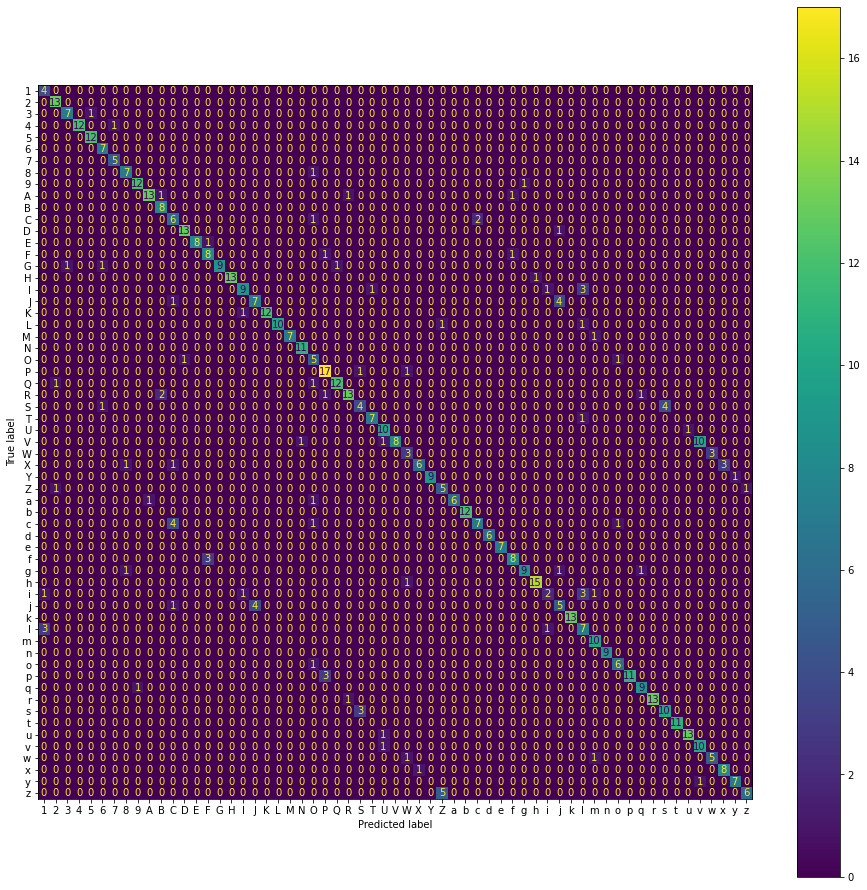

In [153]:
X_train, X_test, y_train, y_test = train_test_split(eng_data_up, eng_labels_up, test_size=0.2, random_state=0)

svm_clf.fit(X_train, y_train)

prediction = svm_clf.predict(X_test)
print(accuracy_score(y_test, prediction))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 16))
plot_confusion_matrix(svm_clf, X_test, y_test, ax=ax)

As expected, a lot of uppercase letters were recognised as lowercase and vice versa.

 Also '1', 'l' and 'i' were mixed up more often than other.

Now let's see the accuracy of the classifier trained to recognise only letter, not the case.

In [154]:
# Checking the classifier on the dataset without uppercase classes
svm_clf = LinearSVC(dual=False, verbose=1)
scores = cross_val_score(svm_clf, eng_data_no_up, eng_labels_no_up, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Accuracy: 0.91 (+/- 0.05)


Accuracy: 0.91 (+/- 0.05)

Let's see the confusion matrix:


[LibLinear]0.936267071320182


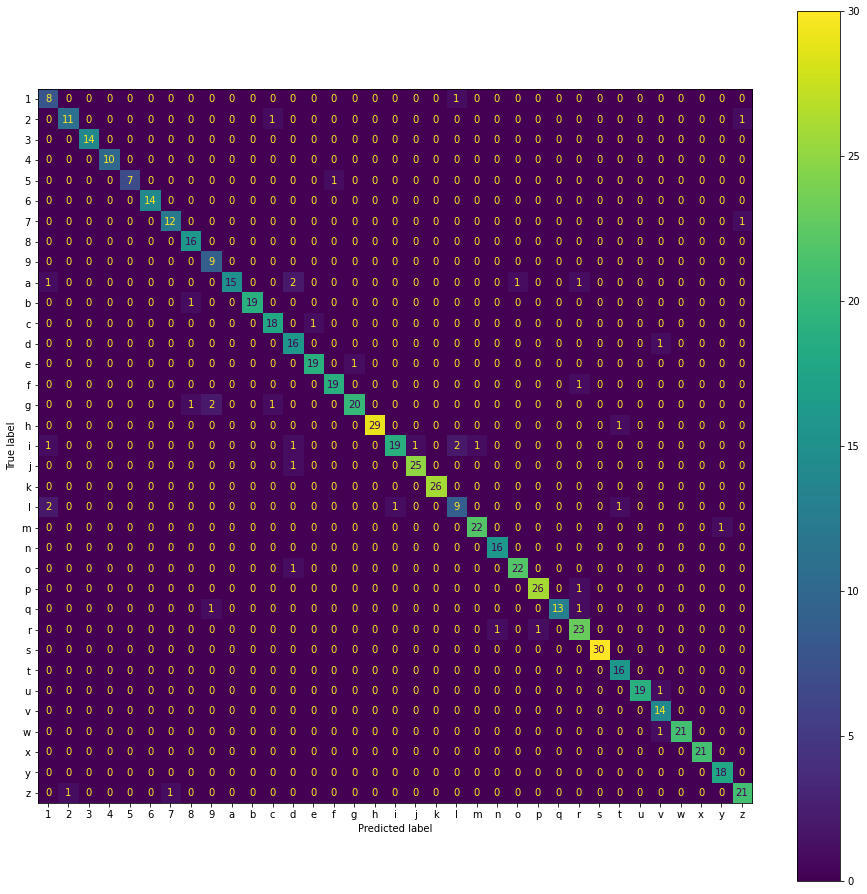

In [155]:
X_train, X_test, y_train, y_test = train_test_split(eng_data_no_up, eng_labels_no_up, test_size=0.2, random_state=0)

svm_clf.fit(X_train, y_train)

prediction = svm_clf.predict(X_test)
print(accuracy_score(y_test, prediction))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16, 16))
plot_confusion_matrix(svm_clf, X_test, y_test, ax=ax)

As it can be seen, if it is no needed to distinguish between lowercase and uppercase letters, classifiers works quite well.

There is still a problem related to  '1', 'l' and 'i' being poorly distinguished, however partially it can be solved by changing the character extractor the way that it will include dot above 'i' to the snippet image.

### 1.2.3 KNN classifier

The accuracy of knn classifier on the dataset with uppercase letters as separate classes. Number of nearest neighbours is taken as 2 using the previous experience with Russian alphabet.

In [156]:
knn_clf_up = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
scores = cross_val_score(knn_clf_up, eng_data_up, eng_labels_up, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.75 (+/- 0.11)


Accuracy: 0.75 (+/- 0.11). As expected, it is less than SVM with 0.84

The accuracy of knn classifier on the dataset without uppercase letters as separate classes:

In [157]:
knn_clf_no_up = neighbors.KNeighborsClassifier(n_neighbors=2, weights='distance')
scores = cross_val_score(knn_clf_no_up, eng_data_no_up, eng_labels_no_up, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.06)


Accuracy: 0.85 (+/- 0.06)

## 1.3 Results

with uppercase classes:

SVM 0.84 (+/- 0.07)

KNN 0.75 (+/- 0.11)

without uppercase classes:

SVM 0.91 (+/- 0.05)

KNN 0.85 (+/- 0.06)

Task 2: Handwritten notes

Task 3: Signature recognition